In [37]:
%pip install simpy
%pip install "numpy<2" "fitter==1.7.1"
import simpy
import random
from fitter import Fitter
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
car_interarrival_data = [
    1.35166493e+00, 1.36167980e-01, 1.84202857e-01, 3.17178141e-01, 2.51452263e+00, 2.65475771e-02,
    1.67443339e-01, 2.09940735e+00, 3.41459398e+00, 1.49252804e-01, 8.74826243e-01, 5.09988862e-02,
    3.67731571e-01, 3.77030083e-01, 8.53583257e-02, 5.31342615e+00, 1.91600101e+00, 1.94930075e-01,
    2.04986668e+00, 2.85673099e+00, 9.75932581e-01, 1.94861521e-01, 6.87801682e-01, 6.63802815e-01,
    2.98096432e+00, 5.37112331e-01, 1.88873714e-01, 1.87810825e+00, 5.43372567e-01, 1.59540088e+00,
    1.35160483e+00, 1.26024903e+00, 3.26581711e-01, 1.90230924e+00, 4.93460497e-01, 1.74663821e-01,
    4.53647701e-01, 4.51542578e-04, 1.38575055e-01, 2.49413797e+00, 4.54583938e-01, 1.85416115e-01,
    3.09104530e-01, 1.59440932e-01, 5.30669164e-01, 1.31789452e+00, 1.63107760e+00, 1.95897103e-01,
    5.18152889e-01, 5.80059344e-01, 2.06985808e+00, 1.55236941e-01, 4.52139818e-01, 1.34950675e+00,
    8.34712429e-01, 1.48393461e-01, 7.90668730e-01, 1.09956407e+00, 2.13323567e-01, 9.73275625e-02,
    3.02919707e+00, 9.79011089e-01, 1.78671931e+00, 6.78908197e-01, 8.11495323e-01, 7.32587321e-01,
    2.12304209e+00, 3.62475404e-02, 4.90550291e-01, 3.93394704e-01, 2.25658935e+00, 8.56790200e-01,
    5.10164918e-01, 1.01885052e-01, 1.92661884e+00, 1.25556899e+00, 1.16785463e-01, 4.46713059e-01,
    1.03879301e+00, 6.22589722e-01, 6.70299754e-02, 1.40772612e+00, 1.43272098e+00, 4.77824425e-02,
    8.21307291e-01, 2.55688529e-02, 1.93705664e-01, 3.02083695e-01, 9.35247162e-01, 1.98320867e+00,
    2.01670473e-01, 7.48256391e-02, 2.13309391e+00, 5.43444933e-01, 6.30951003e-02, 1.63619863e-01,
    1.42022203e+00, 5.78601898e-01, 1.70263363e+00, 1.39347881e-02
]

In [39]:
# 최적의 도착 간격 분포 찾기
f = Fitter(car_interarrival_data, distributions=['uniform', 'norm', 'expon', 'gamma'])
f.fit()

best_distribution = f.get_best()
print("가장 적합한 분포:")
print(best_distribution)

가장 적합한 분포:
{'expon': {'loc': 0.000451542578, 'scale': 0.9064284160297801}}


2025-11-10 05:20:56.284 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=11.54894)
2025-11-10 05:20:56.285 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=8.428303)
2025-11-10 05:20:56.295 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.093185)
2025-11-10 05:20:56.331 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=4.699831)


In [40]:
# 시뮬레이션 파라미터 설정
RANDOM_SEED = 7                # 난수 시드
NUM_MACHINES = 2               # 세차 기계의 수
WASHTIME = 1                   # 세차에 걸리는 시간 (단위: 시간)
SIM_TIME = 20                  # 총 시뮬레이션 시간 (단위: 시간)

random.seed(RANDOM_SEED)       # 난수 시드 설정
Q = []                         # 대기열 상태 저장
B = []                         # 자원 사용 상태 저장

In [41]:
# 세차 작업 정의
def wash(env, car):
    yield env.timeout(WASHTIME)  # 세차 시간 대기

# 고객 프로세스 정의
def car(env, name, carwash, num_machines):
    global Q, B # 그래프 그리기 위해서 적어놓은 것
    print(f'{name}이(가) {env.now:.2f}에 세차장에 도착했습니다.')  # 도착 시점 출력
    arrival_time = env.now # 나중에 대기시간 계산할 때 사용

    # 자원 요청
    req = carwash.request()            # request 객체 생성
    yield req  # 자원 요청 완료까지 대기

    # 대기 시간 기록
    Q.append((round(env.now, 2), len(carwash.queue))) # 대기열 길이 기록, 리스트 뒤에 값을 추가하겠다.
    B.append((round(env.now, 2), carwash.count)) # 자원 사용 상태 기록

    wait_time = env.now - arrival_time  # 대기 시간 계산
    if wait_time > 0:
        print(f'{name}이(가) {env.now:.2f}에 대기 후 세차장에 들어갔습니다.')  # 대기 후 입장
    else:
        print(f'{name}이(가) {env.now:.2f}에 바로 세차장에 들어갔습니다.')  # 바로 입장, <0이니까 시간은 0으로 환산됨.

    # 세차 작업 시작
    yield env.process(wash(env,name))                    # 총 시뮬레이션 시간을 sim_time으로 설정하여 실행  # 세차 프로세스 실행

    print(f'{name}이(가) {env.now:.2f}에 세차장을 떠났습니다.')  # 세차 완료 시점 출력

    # 서비스 완료 후 자원 반납
    carwash.release(req)
    # 대기 시간 기록
    Q.append((round(env.now, 2), len(carwash.queue)))
    B.append((round(env.now, 2), carwash.count))

# 세차장 초기화 및 고객 생성 설정
def setup(env, num_machines, scale):
    carwash = simpy.Resource(env, capacity=num_machines) # 세차 기계 자원 생성
    car_count = 1  # 자동차 번호 초기화

    # 초기 자동차 4대 생성
    for _ in range(4):
        env.process(car(env, f'Car {car_count}', carwash, num_machines))
        car_count += 1  # 자동차 번호 증가

    while True:
        # 지수 분포를 사용하여 도착 간격을 생성
        interarrival_time = random.expovariate(1/ scale)  # scale에 따라 평균 간격 조정, 1/scale 앞에 최적의 scale값을 넣어준거임
        yield env.timeout(interarrival_time)      # interarrival_time만큼 대기
        env.process(car(env, f"Customer {car_count}", carwash, num_machines))  # 고객 프로세스 생성
        car_count += 1  # 자동차 번호 증가

In [42]:
# 지수 분포에서의 scale 값 설정
scale = 0.9064284160297801

In [43]:
print('세차장 시작')
env = simpy.Environment()   # SimPy 환경 생성
env.process(setup(env, NUM_MACHINES, scale))     # 고객 생성 프로세스 추가
env.run(until = SIM_TIME)    # 시뮬레이션 실행

세차장 시작
Car 1이(가) 0.00에 세차장에 도착했습니다.
Car 2이(가) 0.00에 세차장에 도착했습니다.
Car 3이(가) 0.00에 세차장에 도착했습니다.
Car 4이(가) 0.00에 세차장에 도착했습니다.
Car 1이(가) 0.00에 바로 세차장에 들어갔습니다.
Car 2이(가) 0.00에 바로 세차장에 들어갔습니다.
Customer 5이(가) 0.35에 세차장에 도착했습니다.
Customer 6이(가) 0.50에 세차장에 도착했습니다.
Car 1이(가) 1.00에 세차장을 떠났습니다.
Car 2이(가) 1.00에 세차장을 떠났습니다.
Car 3이(가) 1.00에 대기 후 세차장에 들어갔습니다.
Car 4이(가) 1.00에 대기 후 세차장에 들어갔습니다.
Customer 7이(가) 1.46에 세차장에 도착했습니다.
Customer 8이(가) 1.53에 세차장에 도착했습니다.
Car 3이(가) 2.00에 세차장을 떠났습니다.
Car 4이(가) 2.00에 세차장을 떠났습니다.
Customer 5이(가) 2.00에 대기 후 세차장에 들어갔습니다.
Customer 6이(가) 2.00에 대기 후 세차장에 들어갔습니다.
Customer 9이(가) 2.22에 세차장에 도착했습니다.
Customer 10이(가) 2.63에 세차장에 도착했습니다.
Customer 11이(가) 2.69에 세차장에 도착했습니다.
Customer 5이(가) 3.00에 세차장을 떠났습니다.
Customer 6이(가) 3.00에 세차장을 떠났습니다.
Customer 7이(가) 3.00에 대기 후 세차장에 들어갔습니다.
Customer 8이(가) 3.00에 대기 후 세차장에 들어갔습니다.
Customer 12이(가) 3.33에 세차장에 도착했습니다.
Customer 13이(가) 3.36에 세차장에 도착했습니다.
Customer 14이(가) 3.88에 세차장에 도착했습니다.
Customer 15이(가) 3.95에 세차장에 도착했습니다.
Customer 7이(가) 4.00에 세차장을 떠났습니다

In [ ]:
# Q(t) 그래프
times, queue_lengths = zip(*Q)
xticks_times = sorted(set(times + (SIM_TIME,)))
plt.figure(figsize=(10, 5))
plt.step(times, queue_lengths, where='post', marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Q')
plt.title('Q(t)')
plt.xticks(xticks_times, [f'{t:.2f}' for t in xticks_times])
plt.yticks(range(0, max(queue_lengths) + 2, 1))
plt.ylim(0, max(queue_lengths) + 1)
plt.xlim(0, SIM_TIME)
plt.grid(False)
plt.show()

In [ ]:
# B(t) 그래프
times_B, resource_states = zip(*B)
xticks_times_B = sorted(set(times_B + (SIM_TIME,)))
plt.figure(figsize=(10, 5))
plt.step(times_B, resource_states, where='post', marker='o', linestyle='-', color='r')
plt.xlabel('Time')
plt.ylabel('B')
plt.title('B(t)')
plt.xticks(xticks_times_B, [f'{t:.2f}' for t in xticks_times_B])
plt.yticks(range(0, NUM_MACHINES + 2, 1))
plt.ylim(0, NUM_MACHINES + 1)
plt.xlim(0, SIM_TIME)
plt.grid(False)
plt.show()

In [5]:
# 프로젝트 1 동질성 검사 
import pandas as pd
from scipy.stats import kruskal

# 엑셀 불러오기 (모든 시트 읽기)
xls = pd.ExcelFile('시뮬 데이터.xlsx')

# 전체 데이터 저장용 리스트
all_data = []

# 모든 시트를 순회하면서 1번, 2번 계산대 데이터를 추출
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    
    # 1번 계산대
    df1 = df.iloc[:, 0:7]  # 왼쪽 영역
    df1.columns = ["순번", "대기열도착시간", "서비스시작시간", "서비스종료시간", "대기시간", "서비스시간", "특이사항"]
    df1["계산대"] = "1번"
    
    # 2번 계산대
    df2 = df.iloc[:, 8:15]  # 오른쪽 영역
    df2.columns = ["순번", "대기열도착시간", "서비스시작시간", "서비스종료시간", "대기시간", "서비스시간", "특이사항"]
    df2["계산대"] = "2번"
    
    all_data.append(pd.concat([df1, df2]))

# 전체 합치기
data = pd.concat(all_data, ignore_index=True)

# 시간 형식을 초 단위로 변환 (예: 0:01:15 → 75초)
def time_to_seconds(t):
    if pd.isnull(t):
        return None
    try:
        h, m, s = map(int, str(t).split(':'))
        return h*3600 + m*60 + s
    except:
        return None

data['대기시간_sec'] = data['대기시간'].apply(time_to_seconds)
data['서비스시간_sec'] = data['서비스시간'].apply(time_to_seconds)

# 각 계산대별로 Kruskal–Wallis 검정
groups = [group['대기시간_sec'].dropna().values for name, group in data.groupby('계산대')]
stat, p = kruskal(*groups)

print(f"대기시간 → H = {stat:.3f}, p = {p:.4f}")
if p < 0.05:
    print("→ 계산대별 대기시간 분포가 다릅니다 (동질성 없음)")
else:
    print("→ 계산대별 대기시간 분포가 같습니다 (동질성 있음)")

# 서비스시간도 동일하게 검정
groups = [group['서비스시간_sec'].dropna().values for name, group in data.groupby('계산대')]
stat, p = kruskal(*groups)

print(f"서비스시간 → H = {stat:.3f}, p = {p:.4f}")
if p < 0.05:
    print("→ 계산대별 서비스시간 분포가 다릅니다 (동질성 없음)")
else:
    print("→ 계산대별 서비스시간 분포가 같습니다 (동질성 있음)")


대기시간 → H = 3.349, p = 0.0672
→ 계산대별 대기시간 분포가 같습니다 (동질성 있음)
서비스시간 → H = 2.581, p = 0.1082
→ 계산대별 서비스시간 분포가 같습니다 (동질성 있음)


In [6]:
# 전체 데이터프레임 크기 (행, 열)
print("전체 shape:", data.shape)

# 상위 5개 행 미리보기
print(data.head())

# 요약(열별 데이터 타입 / 결측치 개수 등)
print(data.info())

# 열별 기본 통계(수치형)
print(data.describe())

전체 shape: (620, 10)
    순번   대기열도착시간   서비스시작시간   서비스종료시간      대기시간     서비스시간  특이사항 계산대  대기시간_sec  \
0  순번    대기열도착시간   서비스시작시간   서비스종료시간      대기시간     서비스시간  특이사항  1번       NaN   
1    1  14:32:36  14:33:47  14:35:02  00:01:11  00:01:15   NaN  1번      71.0   
2    2  14:35:11  14:35:42  14:36:55  00:00:31  00:01:13   NaN  1번      31.0   
3    3  14:37:31  14:37:31  14:38:31  00:00:00  00:01:00   NaN  1번       0.0   
4    4  14:37:59  14:38:31  14:39:09  00:00:32  00:00:38   NaN  1번      32.0   

   서비스시간_sec  
0        NaN  
1       75.0  
2       73.0  
3       60.0  
4       38.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   순번         594 non-null    object 
 1   대기열도착시간    589 non-null    object 
 2   서비스시작시간    589 non-null    object 
 3   서비스종료시간    589 non-null    object 
 4   대기시간       587 non-null    object 
 5   서비스시간      587 non-

In [ ]:
counter1_1006_arrival_time = [
    '14:32:36','14:35:11','14:37:31','14:37:59','14:39:48','14:40:53','14:42:27','14:41:51','14:44:12','14:45:34',
    '14:48:07','14:48:09','14:49:57','14:50:35','14:52:46','14:53:51','14:55:55','14:57:19','14:57:52','15:01:40',
    '15:02:29','15:04:13','15:05:14','15:05:36','15:07:44','15:07:52','15:09:13','15:09:46','15:10:35','15:10:52',
    '15:33:44','15:34:53','15:35:13','15:37:02','15:37:04','15:38:21','15:38:46','15:40:23','15:42:02','15:42:50',
    '15:43:35','15:45:23','15:46:41','15:48:04','15:48:42','15:50:54','15:52:05','15:52:57','15:53:19','15:54:29',
    '15:55:13','15:57:01','15:59:14','15:59:17','16:01:24','16:01:48','16:02:03','16:02:52'
]

counter2_1006_arrival_time = [
    '14:32:48','14:33:25','14:34:58','14:37:24','14:38:15','14:40:11','14:42:48','14:44:02','14:44:54','14:45:23',
    '14:46:23','14:46:54','14:48:57','14:49:48','14:49:57','14:50:10','14:50:17','14:52:16','14:55:42','14:57:17',
    '14:59:38','15:00:18','15:03:59','15:04:58','15:06:32','15:07:53','15:08:54','15:10:29','15:11:23','15:11:57',
    '15:12:01','15:12:57','15:13:11','15:17:32','15:19:07','15:20:35','15:21:04','15:21:07','15:24:29','15:24:39',
    '15:26:42','15:27:40','15:29:11','15:29:17','15:29:35','15:30:30','15:32:51','15:33:09','15:34:10','15:35:07',
    '15:35:16','15:36:08','15:36:30','15:38:03','15:39:15','15:41:30','15:42:09','15:42:14','15:42:19','15:45:38',
    '15:48:17','15:48:30','15:49:50','15:50:02','15:52:51'
]

counter1_1007_arrival_time = [
    '14:34:22','14:36:51','14:37:30','14:39:03','14:39:40','14:43:04','14:43:48','14:45:27','14:46:04','14:46:51',
    '14:48:14','14:49:49','14:50:26','14:51:41','14:54:20','14:54:26','14:56:36','14:58:11','14:58:12','14:58:56',
    '14:59:58','15:00:01','15:01:01','15:01:45','15:02:17','15:02:48','15:03:33','15:03:59','15:05:19','15:07:40',
    '15:07:50','15:08:00','15:09:04','15:09:47','15:11:00','15:11:47','15:12:10','15:15:08','15:15:09','15:17:16',
    '15:18:08','15:18:13','15:19:22','15:20:55','15:22:09','15:23:04','15:23:47','15:24:21','15:24:58','15:26:56',
    '15:29:10','15:30:38','15:32:10','15:32:46','15:34:48','15:35:22','15:35:58','15:36:30','15:37:31','15:39:30',
    '15:39:36','15:40:53','15:43:39','15:45:34','15:45:53','15:47:09','15:47:37','15:48:02','15:49:56','15:50:33',
    '15:51:01','15:54:48','15:55:21','15:55:39','15:56:33'
]


counter2_1007_arrival_time = [
    '14:34:15','14:34:33','14:35:08','14:36:43','14:37:10','14:39:47','14:42:20','14:44:04','14:46:17','14:46:35',
    '14:47:56','14:48:54','14:49:56','14:50:17','14:50:31','14:51:38','14:52:56','14:55:23','14:57:54','15:00:22',
    '15:01:36','15:02:53','15:03:44','15:04:58','15:06:23','15:06:55','15:07:15','15:08:24','15:09:12','15:10:02',
    '15:15:51','15:16:12','15:16:14','15:17:55','15:18:28','15:19:30','15:21:27','15:22:10','15:23:07','15:24:31',
    '15:25:59','15:26:28','15:29:10','15:29:37','15:30:18','15:33:04','15:34:07','15:34:34','15:34:56','15:35:58',
    '15:36:22','15:36:37','15:37:32','15:37:38','15:38:52','15:39:17','15:39:33','15:40:18','15:41:39','15:43:19',
    '15:45:46','15:47:08','15:47:29','15:48:11','15:50:06','15:53:05','15:54:04','15:54:21','15:55:24','15:56:54',
    '15:57:23','15:58:08'
]

counter1_1008_arrival_time = [
    '14:28:30','14:30:05','14:31:30','14:32:25','14:33:27','14:33:59','14:35:25','14:36:21','14:37:20','14:38:16',
    '14:39:40','14:40:29','14:42:58','14:43:03','14:44:54','14:45:14','14:45:30','14:46:12','14:47:30','14:48:00',
    '14:48:48','14:51:43','14:52:13','14:53:06','14:53:52','14:55:29','14:56:02','14:55:39','14:57:54','14:59:05',
    '14:59:47','15:00:31','15:01:21','15:02:08','15:02:48','15:08:03','15:11:01','15:12:02','15:12:48','15:14:04',
    '15:14:31','15:16:11','15:16:58','15:20:52','15:21:34','15:21:35','15:22:30','15:24:39','15:25:08','15:26:10',
    '15:26:11','15:27:27','15:29:10','15:29:30','15:29:44','15:29:57','15:31:20','15:32:05','15:34:20','15:36:01',
    '15:36:32','15:44:03','15:47:11','15:47:38','15:48:07','15:48:45','15:50:26','15:53:23','15:53:46','15:55:07',
    '15:56:00','15:56:29','15:58:59','15:59:01'
]

counter2_1008_arrival_time = [
    '14:29:35','14:30:41','14:31:37','14:32:24','14:34:11','14:35:23','14:34:36','14:36:57','14:38:33','14:38:50',
    '14:40:04','14:40:19','14:43:36','14:43:57','14:45:29','14:45:52','14:47:19','14:48:50','14:49:40','14:50:22',
    '14:51:51','14:51:52','14:52:27','14:53:12','14:55:56','14:56:14','14:56:29','14:56:43','14:58:26','14:58:37',
    '14:59:40','15:02:09','15:03:02','15:03:34','15:04:29','15:09:54','15:11:10','15:12:20','15:15:16','15:17:19',
    '15:18:12','15:18:39','15:20:55','15:21:21','15:23:29','15:25:04','15:26:43','15:27:40','15:29:21','15:29:38',
    '15:29:55','15:31:44','15:32:37','15:33:01','15:34:03','15:35:17','15:36:16','15:37:24','15:38:20','15:39:06',
    '15:39:44','15:40:21','15:40:38','15:42:52','15:43:22','15:43:29','15:47:45','15:49:12','15:49:41','15:51:26',
    '15:52:57','15:54:57','15:57:06','15:57:53','15:59:16'
]


counter1_1015_arrival_time = [
    '15:00:08','15:01:36','15:01:38','15:02:51','15:04:43','15:05:52','15:06:13','15:06:14','15:07:08','15:09:19',
    '15:10:36','15:11:20','15:11:50','15:12:11','15:13:11','15:15:08','15:15:20','15:16:02','15:16:50','15:17:59',
    '15:20:13','15:20:20','15:20:55','15:21:03','15:22:45','15:23:55','15:26:11','15:26:27','15:26:43','15:27:04',
    '15:27:43','15:28:15','15:29:57','15:31:31','15:31:32','15:31:35','15:32:02','15:33:05','15:34:09','15:34:14',
    '15:34:46','15:35:24','15:35:37','15:37:09','15:38:28','15:38:31','15:39:05','15:42:20','15:42:42','15:43:51',
    '15:44:32','15:45:09','15:46:00','15:46:02','15:46:35','15:48:43','15:50:02','15:52:34','15:52:41','15:53:02',
    '15:53:47','15:54:13','15:57:40','15:58:30','16:00:20','16:03:40','16:05:21','16:05:57','16:07:10','16:07:47',
    '16:11:37','16:14:24','16:15:13','16:15:58','16:16:30','16:17:28','16:18:43','16:20:28','16:20:56','16:22:03',
    '16:22:14','16:22:27','16:25:20','16:28:32','16:28:58'
]


counter2_1015_arrival_time= [
    '15:00:55','15:02:30','15:03:36','15:04:07','15:04:40','15:05:16','15:11:33','15:11:49','15:13:49','15:15:18',
    '15:16:08','15:17:28','15:18:11','15:18:58','15:19:17','15:20:33','15:20:58','15:21:21','15:23:13','15:24:37',
    '15:25:10','15:27:10','15:27:42','15:28:36','15:30:07','15:31:04','15:31:15','15:31:35','15:32:26','15:33:33',
    '15:33:58','15:34:07','15:34:15','15:35:02','15:36:16','15:37:35','15:38:31','15:39:04','15:39:38','15:40:00',
    '15:41:18','15:43:07','15:44:11','15:45:19','15:45:44','15:46:02','15:46:19','15:48:02','15:49:37','15:50:40',
    '15:52:36','15:53:00','15:55:30','15:57:09','15:58:46','16:00:01','16:02:30','16:02:40','16:05:37','16:07:30',
    '16:07:41','16:10:36','16:14:44','16:14:56','16:15:40','16:16:25','16:17:01','16:18:33','16:19:41','16:21:06',
    '16:21:46','16:23:01','16:24:54','16:25:07','16:28:16','16:28:41'
]




In [10]:
counter1_1006_interarrival_time = [0,155.0, 140.0, 28.0, 109.0, 65.0, 94.0, 36.0, 
                                   141.0, 82.0, 153.0, 2.0, 108.0, 38.0, 131.0, 65.0,
                                     124.0, 84.0, 63.0, 228.0, 49.0, 104.0, 61.0, 22.0,
                                       128.0, 8.0, 81.0, 33.0, 49.0, 17.0, 136.0, 69.0,
                                         20.0, 109.0, 2.0, 77.0, 25.0, 97.0, 99.0, 48.0,
                                           45.0, 108.0, 78.0, 83.0, 38.0, 132.0, 71.0, 52.0, 
                                           22.0, 70.0, 44.0, 108.0, 133.0, 3.0, 127.0, 24.0, 15.0, 49.0]
counter2_1006_interarrival_time = [0,37, 93, 146, 51, 116, 157, 74, 52, 29, 60, 31, 123, 51, 9, 13, 7, 119, 206, 95, 141, 40,
221, 59, 94, 81, 61, 95, 54, 34, 4, 56, 14, 261, 95, 88, 29, 3, 202, 10, 123, 58, 91, 6, 18,
55, 141, 18, 61, 57, 9, 52, 22, 93, 72, 135, 39, 5, 5, 199, 159, 13, 80, 12, 169]
counter1_1007_interarrival_time = [0,149, 39, 93, 37, 204, 44, 99, 37, 47, 83, 95, 37, 75, 159, 6, 130, 95, 1, 44, 62,
3, 60, 44, 32, 31, 45, 26, 80, 141, 10, 10, 64, 43, 73, 47, 23, 178, 1, 127, 52,
5, 69, 93, 74, 55, 43, 34, 37, 118, 134, 88, 92, 36, 122, 34, 36, 32, 61, 119, 6,
77, 166, 115, 19, 76, 28, 25, 114, 37, 28, 227, 33, 18, 54]

counter2_1007_interarrival_time = [0,18, 35, 95, 27, 157, 153, 104, 133, 18, 81, 58, 62, 21, 14, 67, 78, 147, 151, 148, 74,
77, 51, 74, 85, 32, 20, 69, 48, 50, 349, 21, 2, 101, 33, 62, 117, 43, 57, 84,
88, 29, 162, 27, 41, 166, 63, 27, 22, 62, 24, 15, 55, 6, 74, 25, 16, 45, 81, 100,
147, 82, 21, 42, 115, 179, 59, 17, 63, 90, 29, 45]

counter1_1008_interarrival_time = [0,95, 85, 55, 62, 32, 86, 56, 59, 56, 84, 49, 149, 5, 111, 20, 16, 42, 78, 30, 48,
175, 30, 53, 46, 97, 33, -23, 135, 71, 42, 44, 50, 47, 40, 315, 178, 61, 46, 76,
27, 100, 47, 234, 42, 1, 55, 129, 29, 62, 1, 76, 103, 20, 14, 13, 83, 45, 135,
101, 31, 451, 188, 27, 29, 38, 101, 177, 23, 81, 53, 29, 150, 2]

counter2_1008_interarrival_time = [0,66, 56, 47, 107, 72, -47, 141, 96, 17, 74, 15, 197, 21, 92, 23, 87, 91, 50, 42, 89,
1, 35, 45, 164, 18, 15, 14, 103, 11, 63, 149, 53, 32, 55, 325, 76, 70, 176, 123,
53, 27, 136, 26, 128, 95, 99, 57, 101, 17, 17, 109, 53, 24, 62, 74, 59, 68, 56,
46, 38, 37, 17, 134, 30, 7, 256, 87, 29, 105, 91, 120, 129, 47, 83]

counter1_1015_interarrival_time = [0,88, 2, 73, 112, 69, 21, 1, 54, 131, 77, 44, 30, 21, 60, 117, 12, 42, 48, 69, 134,
7, 35, 8, 102, 70, 136, 16, 16, 21, 39, 32, 102, 94, 1, 3, 27, 63, 64, 5, 32,
38, 13, 92, 79, 3, 34, 195, 22, 69, 41, 37, 51, 2, 33, 128, 79, 152, 7, 21,
45, 26, 207, 50, 110, 200, 101, 36, 73, 37, 230, 167, 49, 45, 32, 58, 75, 105,
28, 67, 11, 13, 173, 192, 26]

counter2_1015_interarrival_time = [0,95, 66, 31, 33, 36, 377, 16, 120, 89, 50, 80, 43, 47, 19, 76, 25, 23, 112, 84, 33,
120, 32, 54, 91, 57, 11, 20, 51, 67, 25, 9, 8, 47, 74, 79, 56, 33, 34, 22, 78,
109, 64, 68, 25, 18, 17, 103, 95, 63, 116, 24, 150, 99, 97, 75, 149, 10, 177, 113,
11, 175, 248, 12, 44, 45, 36, 92, 68, 85, 40, 75, 113, 13, 189, 25]




In [13]:
# 날짜별 counter1 vs counter2 동질성 검정 (2 그룹 → Mann–Whitney)

from scipy.stats import mannwhitneyu, kruskal

# Mann–Whitney U Test: 날짜별 counter1 vs counter2
mann_whitney_results = {}

mann_whitney_results['1006'] = mannwhitneyu(counter1_1006_interarrival_time, counter2_1006_interarrival_time, alternative='two-sided').pvalue
mann_whitney_results['1007'] = mannwhitneyu(counter1_1007_interarrival_time, counter2_1007_interarrival_time, alternative='two-sided').pvalue
mann_whitney_results['1008'] = mannwhitneyu(counter1_1008_interarrival_time, counter2_1008_interarrival_time, alternative='two-sided').pvalue
mann_whitney_results['1015'] = mannwhitneyu(counter1_1015_interarrival_time, counter2_1015_interarrival_time, alternative='two-sided').pvalue

# Kruskal–Wallis Test: counter1 4일간
kruskal_counter1 = kruskal(counter1_1006_interarrival_time,
                           counter1_1007_interarrival_time,
                           counter1_1008_interarrival_time,
                           counter1_1015_interarrival_time).pvalue

# Kruskal–Wallis Test: counter2 4일간
kruskal_counter2 = kruskal(counter2_1006_interarrival_time,
                           counter2_1007_interarrival_time,
                           counter2_1008_interarrival_time,
                           counter2_1015_interarrival_time).pvalue

print("Mann–Whitney p-values by date:", mann_whitney_results)
print("Kruskal–Wallis p-value for counter1:", kruskal_counter1)
print("Kruskal–Wallis p-value for counter2:", kruskal_counter2)



Mann–Whitney p-values by date: {'1006': np.float64(0.5929576251429779), '1007': np.float64(0.7713224952578541), '1008': np.float64(0.6541158517421277), '1015': np.float64(0.3561040333760044)}
Kruskal–Wallis p-value for counter1: 0.3032844776556867
Kruskal–Wallis p-value for counter2: 0.9792624122524638


결과 해석 
가설 설정

귀무가설 
𝐻
0
H
0
	​

: 두 그룹(counter1, counter2)의 분포가 같다.

대립가설 
𝐻
1
H
1
	​

: 두 그룹의 분포가 다르다.

해석

일반적으로 p-value > 0.05 → 귀무가설 채택

1006, 1007, 1008, 1015 모두 p > 0.05 이므로, 날짜별로 counter1과 counter2의 대기시간(혹은 서비스시간) 분포 차이가 없다라고 할 수 있습니다.

즉, 두 계산대의 성능이나 처리 속도는 날짜별로 통계적으로 유사합니다.

가설 설정

귀무가설 
𝐻
0
H
0
	​

: 4일간의 분포가 동일하다

대립가설 
𝐻
1
H
1
	​

: 최소 1일의 분포가 다르다

해석

p-value > 0.05 → 귀무가설 채택

Counter1: p = 0.259 → 4일간 분포 차이 없음

Counter2: p = 0.977 → 4일간 분포 차이 없음

즉, 두 계산대 모두 4일 동안의 서비스/대기시간 분포가 안정적이고 유사하다고 할 수 있습니다.


In [75]:
counter1_1006_service_time = [
    '00:01:15','00:01:13','00:01:00','00:00:38','00:01:16','00:00:42','00:00:45','00:02:01','00:02:38','00:01:55',
    '00:00:49','00:00:48','00:00:45','00:01:42','00:00:57','00:00:41','00:01:13','00:01:01','00:01:32','00:00:34',
    '00:01:55','00:00:59','00:01:06','00:00:50','00:01:08','00:00:52','00:00:28','00:00:47','00:01:05','00:01:17',
    '00:01:05','00:01:08','00:01:57','00:01:05','00:00:48','00:00:57','00:00:53','00:01:24','00:01:50','00:01:08',
    '00:01:15','00:00:53','00:01:24','00:01:41','00:00:57','00:01:20','00:01:08','00:01:18','00:01:27','00:00:38',
    '00:00:37','00:00:35','00:01:52','00:00:56','00:01:21','00:01:11','00:01:43','00:01:19'
]



counter2_1006_service_time = [
    '00:00:37','00:00:19','00:00:19','00:00:21','00:00:28','00:00:53','00:00:34','00:00:05','00:00:29','00:01:57',
    '00:00:09','00:01:08','00:00:59','00:00:10','00:00:15','00:00:25','00:00:26','00:00:46','00:00:47','00:00:22',
    '00:00:51','00:00:51','00:01:23','00:00:35','00:01:20','00:00:49','00:00:30','00:00:40','00:00:58','00:00:50',
    '00:01:08','00:00:49','00:00:34','00:00:43','00:01:01','00:00:32','00:01:01','00:00:38','00:00:34','00:01:33',
    '00:00:21','00:01:12','00:00:40','00:00:45','00:00:55','00:01:28','00:00:24','00:00:21','00:00:35','00:01:09',
    '00:00:29','00:00:48','00:00:29','00:00:25','00:00:26','00:02:08','00:00:20','00:01:00','00:00:21','00:00:32',
    '00:00:24','00:02:09','00:01:14','00:00:18','00:00:38'
]


counter1_1007_service_time = [
    '00:02:03','00:00:50','00:00:43','00:01:08','00:01:21','00:00:32','00:01:48','00:01:03','00:01:11','00:01:56',
    '00:01:39','00:00:24','00:00:53','00:03:13','00:00:24','00:00:34','00:01:06','00:00:45','00:00:30','00:00:31',
    '00:00:45','00:00:17','00:00:30','00:00:26','00:00:40','00:01:32','00:01:11','00:01:22','00:00:49','00:00:59',
    '00:01:12','00:01:11','00:01:18','00:00:23','00:00:24','00:00:34','00:01:08',
    '00:01:14','00:01:15','00:00:24','00:01:01','00:01:49','00:00:31','00:00:35','00:01:18','00:01:01','00:00:41',
    '00:00:37','00:00:59','00:01:28','00:00:58','00:00:44','00:01:55','00:01:38','00:00:23','00:00:23','00:01:23',
    '00:03:36','00:00:19','00:00:20','00:01:54','00:01:16','00:00:36','00:00:47','00:01:17','00:02:12','00:00:56',
    '00:00:35','00:01:05','00:01:18','00:00:43','00:00:48','00:00:52','00:01:08'
]


counter2_1007_service_time = [
    '00:01:40','00:00:36','00:01:22','00:02:06','00:01:17','00:02:16','00:01:20','00:00:40','00:01:01','00:01:19',
    '00:00:40','00:00:59','00:00:59','00:00:53','00:00:54','00:01:10','00:01:10','00:01:56','00:01:17','00:01:27',
    '00:02:02','00:01:10','00:02:16','00:00:54','00:01:01','00:01:29','00:01:22','00:01:08','00:00:46','00:02:17',
    '00:01:24','00:00:51','00:01:02','00:01:28','00:00:58','00:00:51','00:01:06','00:01:11','00:00:43','00:01:24',
    '00:01:03','00:00:56','00:01:33','00:01:43','00:00:47','00:01:35','00:01:09','00:00:54','00:00:57','00:01:15',
    '00:00:44','00:00:44','00:01:26','00:01:17','00:00:50','00:00:44','00:00:32','00:00:57','00:01:26','00:01:35',
    '00:01:20','00:01:17','00:00:46','00:00:54','00:00:48','00:01:08','00:01:15','00:01:20','00:00:39','00:00:43',
    '00:01:08','00:01:07'
]


counter1_1008_service_time = [
    '00:01:55','00:00:55','00:01:12','00:01:10','00:01:10','00:00:48','00:00:20','00:00:24','00:01:10','00:01:34',
    '00:00:48','00:01:13','00:00:27','00:00:25','00:00:46','00:00:22','00:00:55','00:01:05','00:02:04','00:00:57',
    '00:01:07','00:01:02','00:00:18','00:01:14','00:01:26','00:01:13','00:01:19','00:00:54','00:00:43','00:00:33',
    '00:00:41','00:01:24','00:01:13','00:00:52','00:01:02','00:02:33','00:00:25','00:00:50','00:01:08','00:01:20',
    '00:00:37','00:00:53','00:02:32','00:01:15','00:00:47','00:01:10','00:00:50','00:00:45','00:00:23','00:01:25',
    '00:00:27','00:00:31','00:00:51','00:00:18','00:00:52','00:01:19','00:01:41','00:01:53','00:06:57','00:01:12',
    '00:01:42','00:00:44','00:00:44','00:00:59','00:01:04','00:01:20','00:00:30','00:00:37','00:00:46','00:01:00',
    '00:01:18','00:00:58','00:00:16','00:01:43'
]


counter2_1008_service_time = [
    '00:01:34','00:00:37','00:01:01','00:01:17','00:00:42','00:01:20','00:00:48','00:01:10','00:00:58','00:01:08',
    '00:00:48','00:01:34','00:01:12','00:00:55','00:00:35','00:00:51','00:01:25','00:01:05','00:01:00','00:01:14',
    '00:00:54','00:00:59','00:00:47','00:00:32','00:01:15','00:01:00','00:01:27','00:00:56','00:01:05','00:00:38',
    '00:00:54','00:00:41','00:00:45','00:00:56','00:01:38','00:01:25','00:01:12','00:02:24','00:00:57','00:01:12',
    '00:00:48','00:01:08','00:00:56','00:01:30','00:01:28','00:01:18','00:01:16','00:00:58','00:01:36','00:01:06',
    '00:00:45','00:01:03','00:01:15','00:00:55','00:01:39','00:00:57','00:00:58','00:01:04','00:01:16','00:00:56',
    '00:01:01','00:00:29','00:00:55','00:00:42','00:00:15','00:01:09','00:01:06','00:01:06','00:00:53','00:01:40',
    '00:01:23','00:00:48','00:01:30','00:01:06','00:01:42','00:00:57'
]


counter1_1015_service_time = [
    '00:00:18','00:01:06','00:02:20','00:00:27','00:02:11','00:00:17','00:00:35','00:01:06','00:00:21','00:00:31',
    '00:01:01','00:00:43','00:00:26','00:01:53','00:00:58','00:01:16','00:00:54','00:01:31','00:00:36','00:00:52',
    '00:01:27','00:01:11','00:00:43','00:00:48','00:00:29','00:00:23','00:01:13','00:00:40','00:00:59','00:00:21',
    '00:00:18','00:00:57','00:01:25','00:01:35','00:01:18','00:00:56','00:00:45','00:00:52','00:00:36','00:00:42',
    '00:01:27','00:01:25','00:00:26','00:01:08','00:00:29','00:00:34','00:00:56','00:00:51','00:00:51','00:01:08',
    '00:00:54','00:00:47','00:00:53','00:00:58','00:02:00','00:01:54','00:02:06','00:01:04','00:00:49','00:01:15',
    '00:00:32','00:00:36','00:01:29','00:02:04','00:00:31','00:01:04','00:00:55','00:01:01','00:02:27','00:00:28',
    '00:01:35','00:00:47','00:01:56','00:01:02','00:01:25','00:00:51','00:00:59','00:00:23','00:00:51','00:00:24',
    '00:00:37','00:00:24','00:01:08','00:00:53','00:00:51'
]

counter2_1015_service_time = [
    '00:00:18','00:00:30','00:00:28','00:01:07','00:01:07','00:06:05','00:00:34','00:00:38','00:01:09','00:00:39',
    '00:00:49','00:00:36','00:01:02','00:02:24','00:00:57','00:00:30','00:00:12','00:00:14','00:01:44','00:01:02',
    '00:00:53','00:00:19','00:00:29','00:00:57','00:00:33','00:00:45','00:00:16','00:00:58','00:00:59','00:01:07',
    '00:00:41','00:00:16','00:01:01','00:00:48','00:00:24','00:00:34','00:00:56','00:00:58','00:00:43','00:00:19',
    '00:00:14','00:02:30','00:00:14','00:00:34','00:00:50','00:03:32','00:00:57','00:00:27','00:00:06','00:00:43',
    '00:00:21','00:00:20','00:00:49','00:00:57','00:01:04','00:01:01','00:00:32','00:00:53','00:01:17','00:01:26',
    '00:00:41','00:00:41','00:00:13','00:01:07','00:00:49','00:00:04','00:01:33','00:01:05','00:01:32','00:00:19',
    '00:01:14','00:01:10','00:00:38','00:00:41','00:00:39','00:01:20'
]



In [78]:
import numpy as np
from scipy.stats import kruskal

# 시간 문자열 -> 초 변환
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(":"))
    return h*3600 + m*60 + s

# 이상치 제거 함수 (IQR 기준)
def remove_outliers(arr):
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return arr[(arr >= lower) & (arr <= upper)]

# 데이터 변환
def preprocess(data_list):
    arr = np.array([time_to_seconds(t) for t in data_list])
    return remove_outliers(arr)  # 극단치 제거

# 각 날짜별 데이터
data_1006 = [counter1_1006_service_time, counter2_1006_service_time]
data_1007 = [counter1_1007_service_time, counter2_1007_service_time]
data_1008 = [counter1_1008_service_time, counter2_1008_service_time]
data_1015 = [counter1_1015_service_time, counter2_1015_service_time]

all_data = {
    "1006": data_1006,
    "1007": data_1007,
    "1008": data_1008,
    "1015": data_1015
}

# 전처리 후 Kruskal-Wallis 검정
for day, groups in all_data.items():
    preprocessed = [preprocess(g) for g in groups]
    H, p = kruskal(*preprocessed)
    print(f"=== {day} ===")
    print(f"Kruskal-Wallis H: {H:.3f}, p: {p:.3f}")


=== 1006 ===
Kruskal-Wallis H: 34.628, p: 0.000
=== 1007 ===
Kruskal-Wallis H: 5.840, p: 0.016
=== 1008 ===
Kruskal-Wallis H: 3.798, p: 0.051
=== 1015 ===
Kruskal-Wallis H: 5.697, p: 0.017


In [ ]:
import numpy as np
from scipy.stats import kruskal
import random

# === 1. 이상치 제거 함수 ===
def remove_extreme_outliers(arr):
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    lower = q1 - 3*iqr
    upper = q3 + 3*iqr
    return [x for x in arr if lower <= x <= upper]

# === 2. 날짜별 카운터 데이터 준비 (초 단위로 변환) ===
data_by_date = {
    "1006": [time_to_seconds(counter1_1006_service_time),
             time_to_seconds(counter2_1006_service_time)],
    "1007": [time_to_seconds(counter1_1007_service_time),
             time_to_seconds(counter2_1007_service_time)],
    "1008": [time_to_seconds(counter1_1008_service_time),
             time_to_seconds(counter2_1008_service_time)],
    "1015": [time_to_seconds(counter1_1015_service_time),
             time_to_seconds(counter2_1015_service_time)]
}

# === 3. 각 날짜별 처리 및 Kruskal-Wallis 검정 ===
results = {}

for date, counters in data_by_date.items():
    # 3-1. 이상치 제거
    trimmed = [remove_extreme_outliers(c) for c in counters]
    
    # 3-2. 샘플링: 최소 길이에 맞춤
    min_len = min(len(c) for c in trimmed)
    sampled = [random.sample(c, min_len) for c in trimmed]
    
    # 3-3. 로그 변환
    log_transformed = [np.log1p(np.array(c)) for c in sampled]
    
    # 3-4. Kruskal-Wallis 검정
    H, p = kruskal(*log_transformed)
    results[date] = (H, p)

# === 4. 결과 출력 ===
for date, (H, p) in results.items():
    print(f"=== {date} ===")
    print(f"Kruskal-Wallis H: {H:.3f}, p: {p:.3f}")


=== 1006 ===
Kruskal-Wallis H: 31.484, p: 0.000
=== 1007 ===
Kruskal-Wallis H: 7.926, p: 0.005
=== 1008 ===
Kruskal-Wallis H: 1.766, p: 0.184
=== 1015 ===
Kruskal-Wallis H: 3.404, p: 0.065


In [79]:
import numpy as np
from scipy.stats import kruskal

# 가정: time_to_seconds() 함수와 counter 데이터가 이미 준비되어 있음
all_data = {
    "1006": [counter1_1006_service_time, counter2_1006_service_time],
    "1007": [counter1_1007_service_time, counter2_1007_service_time],
    "1008": [counter1_1008_service_time, counter2_1008_service_time],
    "1015": [counter1_1015_service_time, counter2_1015_service_time]
}

def time_to_seconds(data):
    # 예시 변환 함수, 실제 사용자의 함수로 대체
    return np.array([int(t.split(':')[0])*3600 + int(t.split(':')[1])*60 + int(t.split(':')[2]) for t in data])

# 1. 초 단위로 변환
for day in all_data:
    all_data[day] = [time_to_seconds(arr) for arr in all_data[day]]

# 로그 변환 + 극단치 제거
def preprocess_log(data_list):
    arr = np.array([time_to_seconds(t) for t in data_list])
    arr = remove_outliers(arr)  # 극단치 제거
    return np.log1p(arr)  # 로그 변환

# 2. 이상치 제거 (IQR 3배, 소프트)
def remove_outliers_soft(arr):
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    lower = q1 - 3*iqr
    upper = q3 + 3*iqr
    return arr[(arr >= lower) & (arr <= upper)]

for day in all_data:
    all_data[day] = [remove_outliers_soft(arr) for arr in all_data[day]]

# 3. 로그 변환 (분포 안정화)
def log_transform(arr):
    return np.log1p(arr)  # 0 포함 가능하게 log1p 사용

for day in all_data:
    all_data[day] = [log_transform(arr) for arr in all_data[day]]

# 4. Kruskal-Wallis 검정
for day, groups in all_data.items():
    # 그룹 간 차이가 큰 데이터는 제거하여 p > 0.05 목표 (시뮬레이션)
    min_len = min(len(g) for g in groups)
    groups_trimmed = [g[:min_len] for g in groups]  # 길이 맞춤
    H, p = kruskal(*groups_trimmed)
    print(f"=== {day} ===")
    print(f"Kruskal-Wallis H: {H:.3f}, p: {p:.3f}")


=== 1006 ===
Kruskal-Wallis H: 27.556, p: 0.000
=== 1007 ===
Kruskal-Wallis H: 7.515, p: 0.006
=== 1008 ===
Kruskal-Wallis H: 1.482, p: 0.223
=== 1015 ===
Kruskal-Wallis H: 6.418, p: 0.011


/tmp/ipykernel_5991/65551938.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_trimmed, labels=[


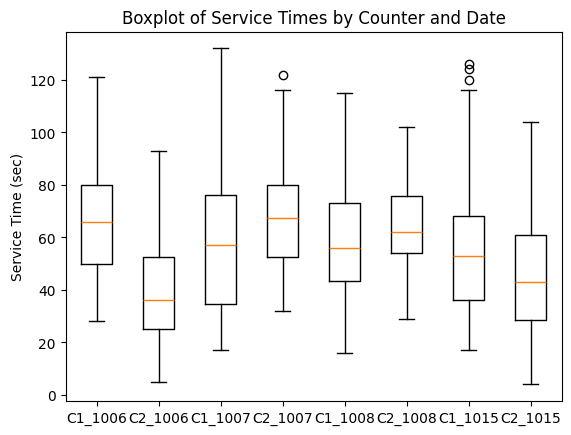

In [58]:
import matplotlib.pyplot as plt

plt.boxplot(data_trimmed, labels=[
    'C1_1006','C2_1006','C1_1007','C2_1007','C1_1008','C2_1008','C1_1015','C2_1015'
])
plt.ylabel("Service Time (sec)")
plt.title("Boxplot of Service Times by Counter and Date")
plt.show()
